In [1]:
import os

In [2]:
# Downloads all the corresponding data from source and unzips them

# Checks if its not already downloaded, downloads it and extract it
if 'images.tar' not in os.listdir('./data'):
    !wget --directory-prefix ./data http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar data/
    !tar -xf ./data/images.tar -C ./data

--2020-04-16 13:06:39--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘./data/images.tar’

images.tar          100%[===================>] 756.82M  21.3MB/s    in 35s     

2020-04-16 13:07:14 (21.4 MB/s) - ‘./data/images.tar’ saved [793579520/793579520]

--2020-04-16 13:07:14--  http://data/
Resolving data (data)... failed: No address associated with hostname.
wget: unable to resolve host address ‘data’
FINISHED --2020-04-16 13:07:14--
Total wall clock time: 36s
Downloaded: 1 files, 757M in 35s (21.4 MB/s)


# Data Exploration and Preparation

This notebook will rundown on some preparation for the dog breed dataset. We will look for incosistencys on the data and the distribution of samples between classes.

Since this is a public dataset and is already well curated this part could be ignored, but in a real world problem this would not be the case. So because of it this part is presented here!

---

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import re

from sklearn.model_selection import train_test_split
from scipy import stats
from glob import glob
from PIL import Image


The cell below serves to see if all images and classes are present, that means, if the archives were downloaded correctly..

In [4]:
classes_dir = glob('./data/Images/*')
images_path_list = [img for img in glob('./data/Images/*/*')]

# Assert if all classes present
assert 120 == len(classes_dir),  "Something wrong with the dirs"
assert 20580 == len(images_path_list), "Something wrong with the images"

We can see the samples per class are well distributed, that means that there is not a great class imbalance that could generate big bias on our models!

DescribeResult(nobs=120, minmax=(148, 252), mean=171.5, variance=539.2100840336135, skewness=1.1129454577500337, kurtosis=0.5650105173577553)


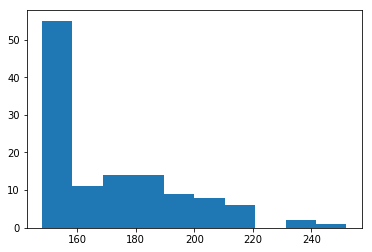

In [5]:
items_in_classes = [len(glob(dog_breed + '/*')) for dog_breed in classes_dir]
print(stats.describe(items_in_classes))
plt.hist(items_in_classes)
plt.show()

## Visualizing Dataset

Here we can take a glance at images of the dogs. There are 11 dogs of 9 different breeds represented below.

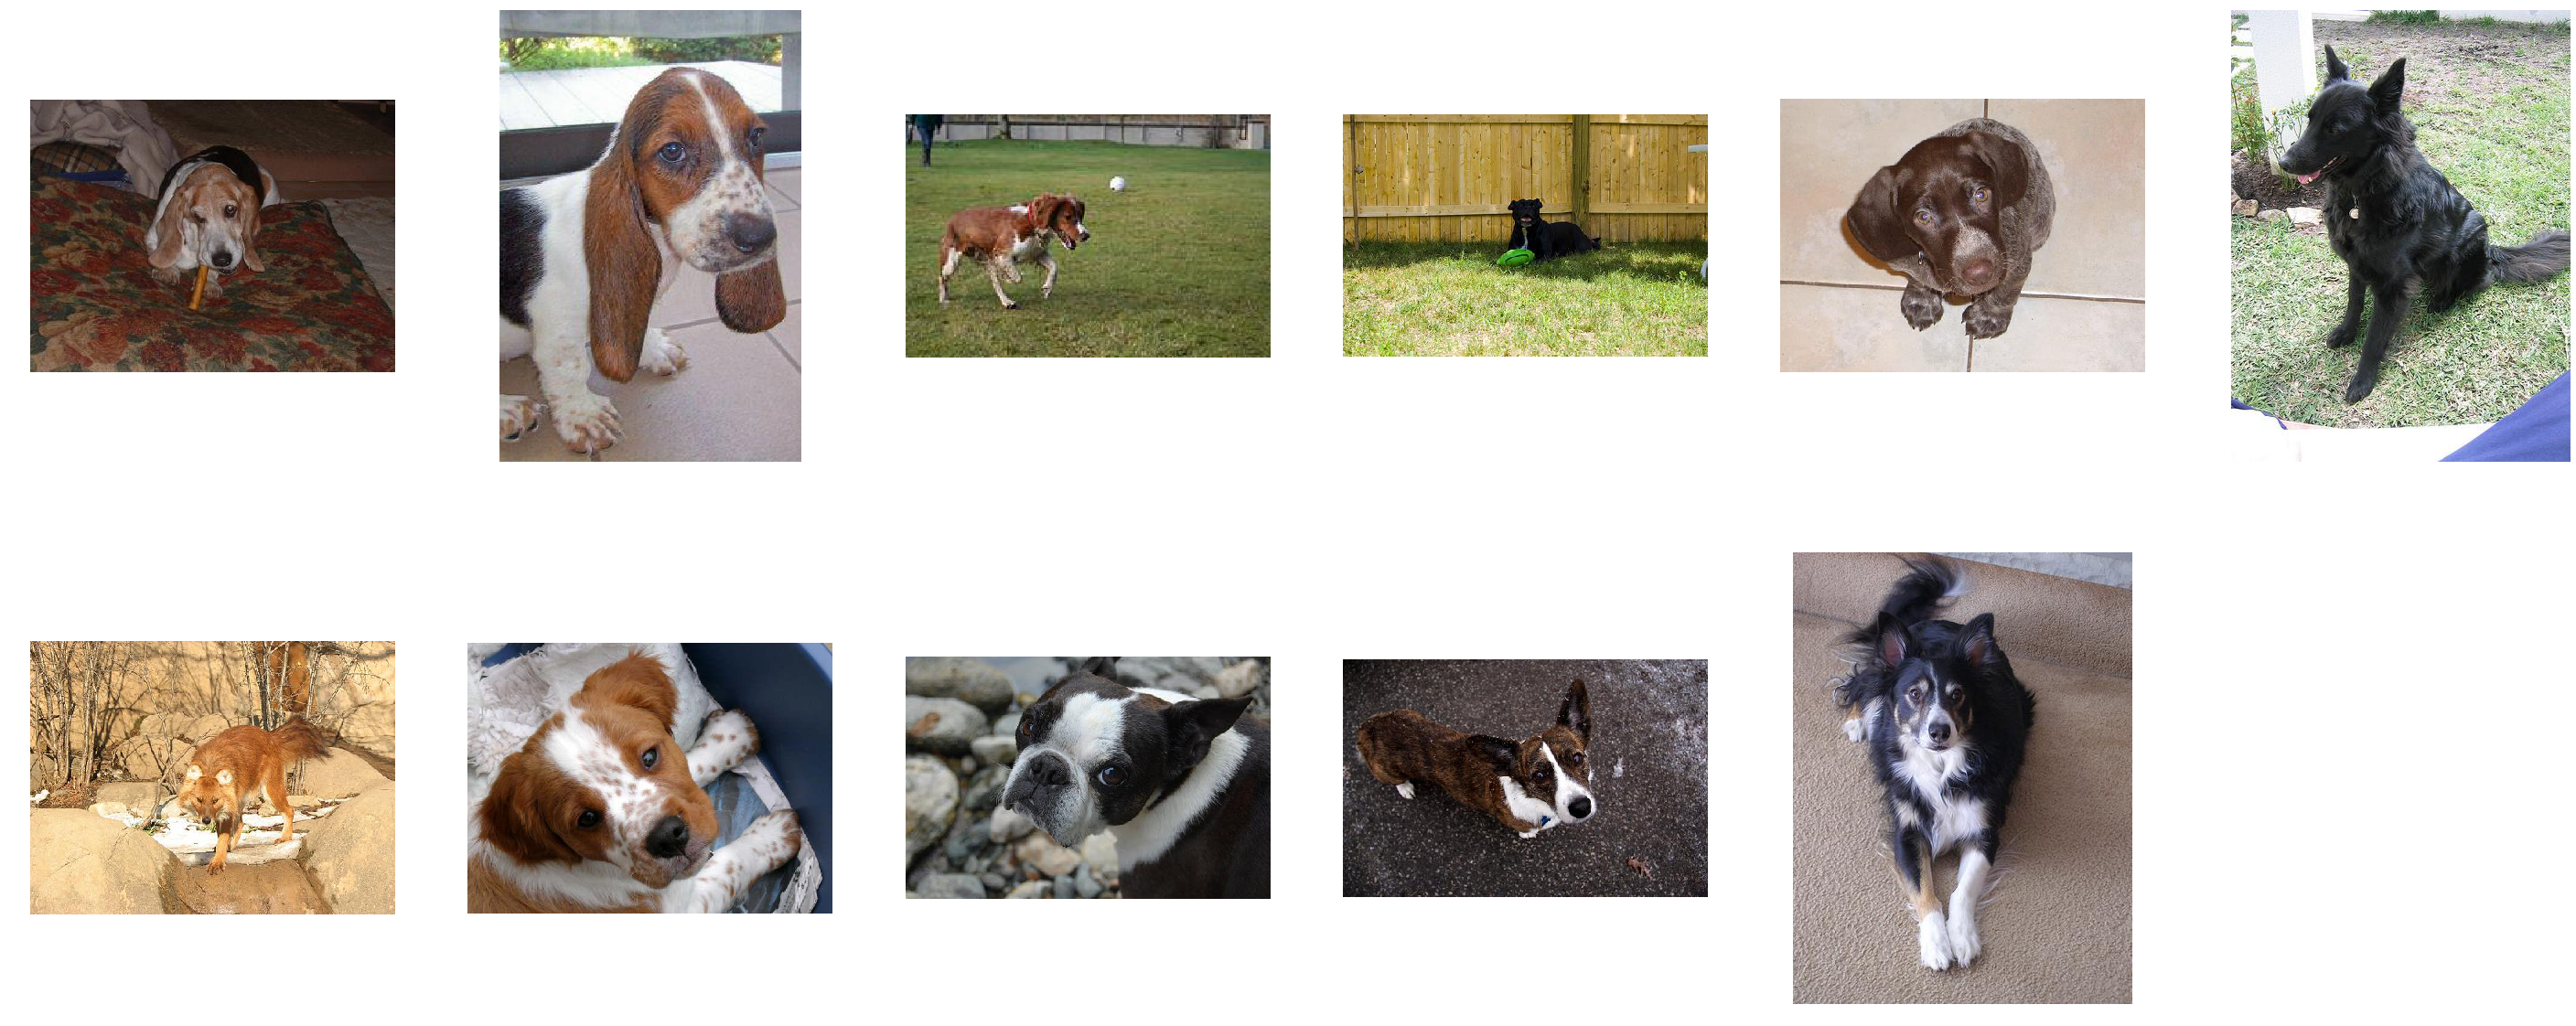

In [6]:
plt.figure(figsize=(50,20))
for ix, img_path in enumerate(images_path_list[:1701:170]):
    plt.subplot(2, 6, ix+1)
    plt.axis("off")
    plt.imshow(Image.open(img_path))
plt.show()

## Checking for integrity

It's necessary to know if our data is right or not. The cell bellow does that.

It checks if the image actually exists and if its possible to make operation on it. Thats a good way to confirm if an image is not corrupted and, well, its a sample of the transformations we will be needing to do on the data..

In [7]:
# How to check integrity of Image with PIL: https://stackoverflow.com/a/53470950
for image_path in images_path_list:
    try:
        img = Image.open(image_path)
        img.verify() # checks for defects
        img.close() # flushs memory
        img = Image.open(image_path) 
        img.transpose(Image.FLIP_LEFT_RIGHT) # make a operation to be sure everything is ok
        img.close()
    except Exception as e: 
        print(f"File: {image_path}, has encountered error: {e}")

If the cell above ran without any output then everything is ok! 

## Making a DataFrame for the Dataset

We take all the classes names from their respective folders, clean them with regex, and construct a pandas DataFrame with the class name and its respective path. This will help us to prepare the data to the test split and furter preparations.

In [8]:
class_names = [re.findall("\/.*\d(-.*)", item)[0] for item in classes_dir]
print(class_names[:10])

['-basset', '-otterhound', '-Welsh_springer_spaniel', '-Staffordshire_bullterrier', '-German_short-haired_pointer', '-groenendael', '-dhole', '-Brittany_spaniel', '-Boston_bull', '-Cardigan']


In [9]:
df = pd.DataFrame(images_path_list, columns=['path'])
df["breed"] = [breed for path in df.path for breed in class_names if breed in path]
df.breed = df.breed.str.replace('-', '').str.lower()

In [10]:
df.head()

,path,breed
0,./data/Images/n02088238-basset/n02088238_9360.jpg,basset
1,./data/Images/n02088238-basset/n02088238_7131.jpg,basset
2,./data/Images/n02088238-basset/n02088238_9635.jpg,basset
3,./data/Images/n02088238-basset/n02088238_10183...,basset
4,./data/Images/n02088238-basset/n02088238_10757...,basset


## Separating test, train, validation datasets

It was chosen a split of 70% train 25% test and 5% val. This can be changed to other values.

A important thing to say is that the train test split is stratified. That means that the distribution of classes will be the same between both test and train split data, this will help to reduce bias.

In [11]:
train_df, test_df = train_test_split(df, 
                               test_size=0.3,
                               random_state=42,
                               shuffle=True,
                               stratify=df.breed)

In [12]:
test_df, val_df = train_test_split(test_df,
                                   test_size=0.15,
                                   random_state=42,
                                   shuffle=True)

In [13]:
print(f'Size of train data: {len(train_df)} \nSize of test data: {len(test_df)} \nSize of validation data: {len(val_df)}')

Size of train data: 14406 
Size of test data: 5247 
Size of validation data: 927


In [14]:
print(f'Classes on train data: {len(train_df.breed.unique())}' 
      f'\nClasses on test data: {len(test_df.breed.unique())}'
      f'\nClasses on validation data: {len(val_df.breed.unique())}')

Classes on train data: 120
Classes on test data: 120
Classes on validation data: 120


## Saving Dataset to folder

We then separate all our data in their respective folders so that we can use something like PyTorch FolderImageDataLoader on them!

In [15]:
import shutil

In [16]:
for item, df in zip(['train', 'test', 'val'], [train_df, test_df, val_df]):
    if not os.path.exists(f'./data/dataset/{item}'):
        os.makedirs(f'./data/dataset/{item}')
    for file in df.path:
        file_class = df[df.path == file].breed.values[0]
        if not os.path.exists(f'./data/dataset/{item}/{file_class}'):
            os.makedirs(f'./data/dataset/{item}/{file_class}')
        shutil.copy(file, f'./data/dataset/{item}/{file_class}/')

Checking if the copy went allright!

In [17]:
assert len(train_df) == len(glob('./data/dataset/train/*/*')), "Something bad ocorred on the creation of train folder. Run the cell above again"
assert len(test_df) == len(glob('./data/dataset/test/*/*')), "Something bad ocorred on the creation of test folder. Run the cell above again"
assert len(val_df) == len(glob('./data/dataset/val/*/*')), "Something bad ocorred on the creation of validation folder. Run the cell above again"

In [18]:
assert len(train_df.breed.unique()) == len(glob('./data/dataset/train/*')), "Something bad ocorred on the creation of train folder. Num of classes not equal"
assert len(test_df.breed.unique()) == len(glob('./data/dataset/test/*')), "Something bad ocorred on the creation of test folder. Num of classes not equal"
assert len(val_df.breed.unique()) == len(glob('./data/dataset/val/*')), "Something bad ocorred on the creation of validation folder. Num of classes not equal"